In [10]:
import sys
import os
import random
import time
import pandas as pd
import numpy as np
import networkx as nx
from networkx import algorithms
from networkx.utils import groups

from itertools import chain, combinations
from collections import deque 
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy import stats

from typing import List, Set, Dict, Optional, Union

from linearmodels.iv import IVGMM
import scipy.linalg as slg
import statsmodels.api as sm

import warnings
import inspect
import re

sys.path.append("../src")
from identification_strategy_finder import NIVStrategyFinder

#### Helpers

In [11]:
def simulate_linear_SCM(G, n_samples):
    """
    Simulate data from a linear Structural Causal Model (SCM) compatible with a directed acyclic graph (DAG).

    Inputs:
    - G:         Directed acyclic graph (DAG, networkx) defining the SCM.
    - n_samples: Number of samples to generate.

    Outputs:
    - df: DataFrame containing the simulated data.
    - true_coefficients: Dictionary of true coefficients for each edge in the graph.
    """
    edge_weights = {edge: np.random.uniform(2, 4) for edge in G.edges()}
    true_coefficients = {}

    data = {}
    for node in nx.topological_sort(G):
        parents = list(G.predecessors(node))
        if not parents:
            data[node] = np.random.normal(0, 1, n_samples)
            true_coefficients[node] = {}
        else:
            data[node] = np.zeros(n_samples)
            true_coefficients[node] = {}
            for parent in parents:
                true_coefficients[node][parent] = edge_weights[
                    (parent, node)
                ]
                data[node] += data[parent] * edge_weights[(parent, node)]
            data[node] += np.random.normal(0, 1, n_samples)
    df = pd.DataFrame(data)
    return df, true_coefficients

def posinv(A):
    """
    Compute the inverse of a positive-definite matrix using Cholesky decomposition.

    Inputs:
    - A: Positive-definite matrix.

    Outputs:
    - inv: Inverse of matrix A.
    """
    cholesky, info = slg.lapack.dpotrf(A)
    if info != 0:
        raise np.linalg.LinAlgError("Singular or non-pd Matrix.")
    inv, info = slg.lapack.dpotri(cholesky)
    if info != 0:
        raise np.linalg.LinAlgError("Singular or non-pd Matrix.")
    inv += np.triu(inv, k=1).T
    return inv


def col_bind(*args):
    """
    Concatenate arrays column-wise.

    Inputs:
    - args: List of arrays to concatenate.

    Outputs:
    - Concatenated array with columns bound.
    """
    return np.concatenate([get_2d(a) for a in args], axis=1)


def row_bind(*args):
    """
    Concatenate arrays row-wise.

    Inputs:
    - args: List of arrays to concatenate.

    Outputs:
    - Concatenated array with rows bound.
    """
    return np.concatenate(args, axis=0)


def get_2d(a):
    """
    Reshape a 1- or 2-d numpy-array to be 2-dimensional.

    Inputs:
    - a: Array of shape (n,) or (n, m).

    Outputs:
    - Reshaped array of shape (n, 1) or (n, m).
    """
    if len(a.shape) <= 1:
        a = a.reshape(-1, 1)
    return a


def cov(a, b=None):
    """
    Compute cross-covariance matrix between arrays a and b.
    If b is None, covariance matrix of a is returned.

    Inputs:
    - a: Array of shape n_obs OR (n_obs, dims_a)
    - b: None or array of shape n_obs OR (n_obs, dims_b)

    Outputs:
    - Covariance matrix of shape (dims_a, dims_b)
    """
    a = get_2d(a)
    b = a if b is None else get_2d(b)

    d_a = a.shape[1]

    Sigma = np.cov(col_bind(a, b).T)
    return Sigma[:d_a, d_a:]


def civ(
    X,
    Y,
    I,
    B=None,
    N=None,
    W=None,
    predict=lambda x, b: sm.OLS(x, b).fit().predict(),
):
    """
    Compute the causal effect of X,N on Y using instrument I and conditioning set B.

    Inputs:
    - X:        Regressor. numpy array [shape (n_obs,) OR (n_obs, dims_X)]
    - Y:        Response. numpy array [shape (n_obs,) OR (n_obs, dims_Y)]
    - I:        Instrument. numpy array [shape (n_obs,) OR (n_obs, dims_I)]
    - B:        Conditioning set. numpy array [shape (n_obs,) OR (n_obs, dims_B)]
    - N:        Nuisance regressor. numpy array [shape (n_obs,) OR (n_obs, dims_B)]
    - W:        Weight matrix [shape (dims_I, dims_I)]
                or a tuple (Weight matrix W, Weight matrix factor L s.t. W=LL')
    - predict:  function(X, B) that predicts X from B

    Outputs:
    - Estimated causal effect; numpy array (dims_X+dims_N, dims_Y)
    """
    if B is not None:
        r_X = get_2d(X) - get_2d(predict(get_2d(X), get_2d(B)))
        r_Y = get_2d(Y) - get_2d(predict(get_2d(Y), get_2d(B)))
        r_I = get_2d(I) - get_2d(predict(get_2d(I), get_2d(B)))
        if N is not None:
            r_N = get_2d(N) - get_2d(predict(get_2d(N), get_2d(B)))
        return civ(r_X, r_Y, r_I, B=None, W=W, N=(r_N if N is not None else None))
    else:
        if W is None:
            try:
                W = posinv(cov(I))
            except np.linalg.LinAlgError as e:
                e.args += (
                    "Instruments may have degenerate covariance matrix; "
                    "try using less instruments.",
                )
                warnings.warn(
                    e.args[0]
                    + "Instruments may have degenerate covariance matrix; "
                    + "try using less instruments.",
                    slg.LinAlgWarning,
                    stacklevel=3,
                )
                W = np.eye(I.shape[1])

        if type(W) is not tuple:
            W = (W, slg.lapack.dpotrf(W)[0].T)

        regressors = X if N is None else col_bind(X, N)
        covregI = cov(regressors, I)
        covIY = cov(I, Y)
        weights = W[0]
        cho = covregI @ W[1]

        estimates = slg.solve(
            cho @ cho.T, covregI @ weights @ covIY, assume_a="pos"
        )

        return estimates

#### Draw the DAG 

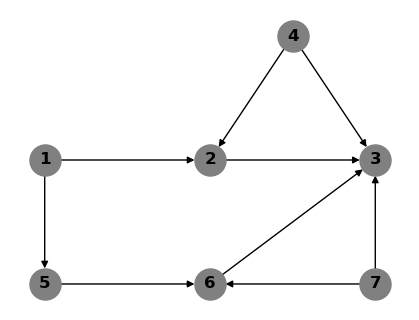

In [13]:
G = nx.DiGraph()
G.add_edges_from([(1,2), (2,3), (4,2), (4,3),
                  (1,5), (5,6), (6,3), (7,6), (7,3)])
pos = {
    1: (0, 0),
    2: (2, 0),
    3: (4, 0),
    4: (3, 1),
    5: (0, -1),
    6: (2, -1),
    7: (4, -1)
}

plt.figure(figsize=(4, 3))
nx.draw(G, pos = pos, with_labels=True, node_size=500, node_color="grey", font_size=12, font_weight="bold")
plt.show()

#### Run the experiment

In [14]:
sample_sizes = np.logspace(2, 6, num=18, base=10, dtype=int)
n_seeds = 20

res_civ_diffs_avg = []
res_second_diffs_avg = []

for n_samples in sample_sizes:
    res_civ_diffs = []
    res_second_diffs = []
    
    for seed in range(n_seeds):
        np.random.seed(seed)
        data, coefficients = simulate_linear_SCM(G, n_samples)
        
        true_coeff = coefficients[3][2]
        res_civ = civ(X=np.array(data[2]),
                      Y=np.array(data[3]),
                      I=np.column_stack((np.array(data[5]), np.array(data[1]))),
                      N=np.array(data[6])) 
        res_civ_diff = abs(res_civ[0] - true_coeff)
        res_civ_diffs.append(res_civ_diff)
        
        res_nuis = civ(X=np.array(data[6]),
                       Y=np.array(data[3]),
                       I=np.array(data[5]),
                       B=np.array(data[1])) 

        data["Y_proj"] = data[3] - res_nuis[0] * data[6]

        res_second = civ(X=np.array(data[2]),
                         Y=np.array(data["Y_proj"]),
                         I=np.array(data[1]))
        res_second_diff = abs(res_second[0] - true_coeff)
        res_second_diffs.append(res_second_diff)
    
    res_civ_diffs_avg.append(np.mean(res_civ_diffs))
    res_second_diffs_avg.append(np.mean(res_second_diffs))

results_df = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Res CIV Diff Avg": res_civ_diffs_avg,
    "Res Second Diff Avg": res_second_diffs_avg
})

results_df.to_pickle("./results/consistency_data.pkl")

#### Plot

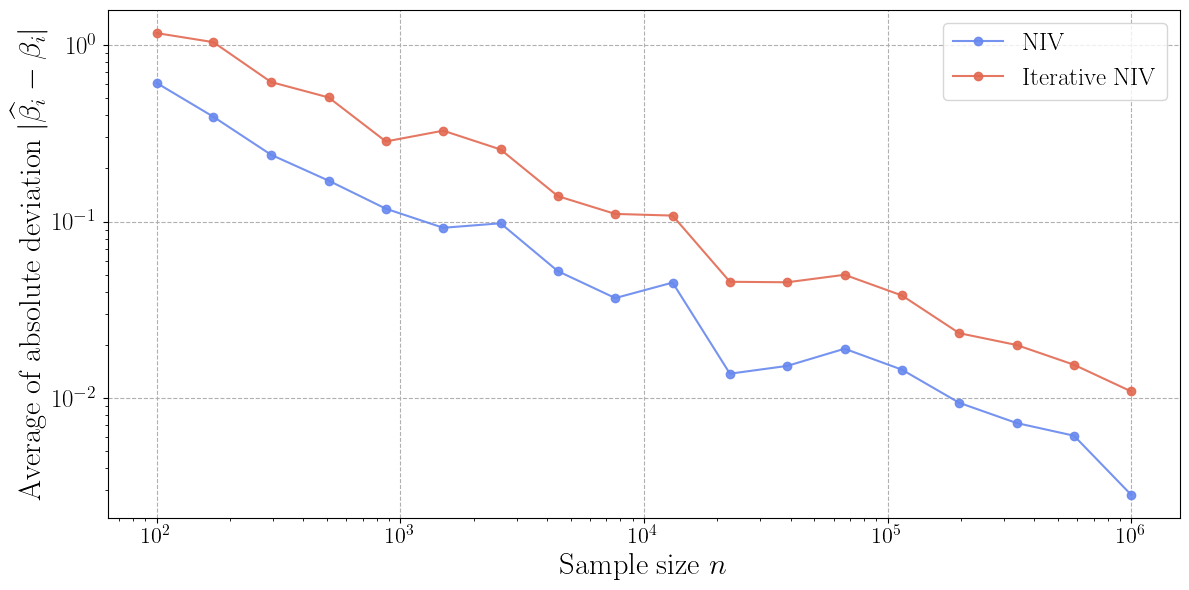

In [15]:
df_results = pd.read_pickle("./results/consistency_data.pkl")
sample_sizes = np.logspace(2, 6, num=18, base=10, dtype=int)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    "axes.labelsize": 22,     
    "xtick.labelsize": 16,    
    "ytick.labelsize": 18,    
    "legend.fontsize": 18,    
    "figure.titlesize": 22,   
    "axes.titlesize": 22,
    "legend.title_fontsize": 22
})

fig, ax = plt.subplots(figsize=(12, 6))
palette = sns.color_palette("coolwarm", 6)

ax.plot(sample_sizes, res_civ_diffs_avg, label='NIV', color=palette[0], marker = "o", alpha = 0.9)
ax.plot(sample_sizes, res_second_diffs_avg, label='Iterative NIV', color=palette[-1], marker = "o", alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Sample size $n$')
ax.set_ylabel(r'Average of absolute deviation $|\widehat{\beta}_i - \beta_i|$')
ax.legend()
ax.grid(True, which="major", linestyle='--')

plt.tight_layout()
plt.savefig("./plots/figure_7_1.svg", format="svg")
plt.show()